# Greenland Ice Sheet Model Plotting Example

This Jupyter notebook can be used to plot an ice sheet model directly in the notebook.

The program runs using a single ice sheet model file in netcdf format. The code run during each process is shown below its short description.

After running the basic processing and plotting cells the ice sheet model can be viewed within the notebook.

## Importing Python Packages

In [12]:
#this import must come first
import hublib.use
#used to enable correct environment for use of all packages
%use xarray_anaconda_6

import os,sys

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import numpy as np

import xarray as xr

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

sys.path.insert(0, os.path.abspath('..'))

import ipywidgets as widgets

## Loading Ice Sheet Model
The file uploaded must be in netcdf(.nc) format. The ice sheet model is then converted from netCDF format into an Xarray.

In [13]:
#this netCDF file is stored locally for the use of this tool
nc_filename = 'data/lithk_GIS_IMAU_IMAUICE1_asmb.nc'

# Loading the Ice Sheet Model in netCDF format into an Xarray
gis_ds = xr.open_dataset(nc_filename, engine='netcdf4')
    
lithk = gis_ds['lithk']
lithk_proj = gis_ds['Polar_Stereographic']

## Set Polar Stereographic Projection Definition
The projection can be defined using model projection information pulled from the Xarray of the converted netCDF file, or using a standard definition.

In [14]:
#can be "model based" or "standard"
projection_choice = 'model based'

if projection_choice == 'model based':
    # # Method 1: Set model projection from model projection information
    polar_stereographic = ccrs.Stereographic(
        central_latitude=lithk_proj.latitude_of_projection_origin,
        central_longitude=lithk_proj.straight_vertical_longitude_from_pole,
        false_easting=lithk_proj.false_easting,
        false_northing=lithk_proj.false_northing,
        true_scale_latitude=lithk_proj.standard_parallel,
        globe=ccrs.Globe('WGS84'))
    
elif projection_choice == 'standard':
    # Method 2: Set model projection from standard definition
    polar_stereographic = ccrs.Stereographic(
        central_latitude=90.0,
        central_longitude=-45.0,
        false_easting=0.0,
        false_northing=0.0,
        true_scale_latitude=70.0,
        globe=ccrs.Globe('WGS84'))

## Transform Projection
Using the information from the Xarray, the projection can be transformed into a latitude/longitude based format.

In [15]:
# Transform projection to lat/lon
geodetic = ccrs.Geodetic(globe=ccrs.Globe('WGS84'))

yv, xv = np.meshgrid(gis_ds.y.data, gis_ds.x.data)

ll = geodetic.transform_points(src_crs=polar_stereographic, x=xv.flatten(), y=yv.flatten())
lons = ll[:,0]
lats = ll[:,1]

# Calculating mean field so we have a single field to plot
lithk_mean = lithk.mean(dim='time').data
lithk_mean = lithk_mean.transpose()
lithk_mean = lithk_mean.flatten()

## Plot Ice Sheet Model


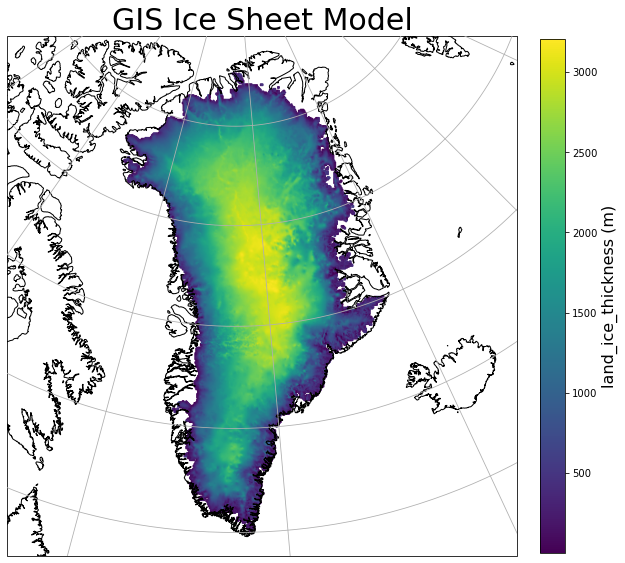

In [16]:
# Plot transformed data
plt.figure(figsize=(10,10))

ax = plt.axes(projection=polar_stereographic)
ax.set_extent([-65, -20, 57, 84]) # Map bounds, [west, east, south, north]

# Sets the title of the model plot
ax.set_title('GIS Ice Sheet Model', fontsize=30)
cs = plt.scatter(lons, lats, 1, c=lithk_mean, transform=ccrs.Geodetic(), zorder=0, cmap='viridis')

c = plt.colorbar(fraction=0.046, pad=0.04)
c.set_label('{0} ({1})'.format(gis_ds.lithk.attrs['standard_name'], gis_ds.lithk.attrs['units']), size=16)

ax.coastlines(resolution='10m', zorder=7)
ax.gridlines(zorder=8)

plt.show()

#this process may take a moment